In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from tqdm import tqdm

import atomai as aoi
import torch
import random

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.spatial.distance import cdist

/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_927/4293410420.py:11: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter
/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_927/4293410420.py:12: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_927/4293410420.py:12: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion


In [2]:
def load_images_from_folder(folder_path):
    images = []
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".txt") ]
    
    for filename in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(folder_path, filename)
        img = np.loadtxt(img_path)
        normalizedData = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        normalizedData = cv.resize(normalizedData, (512,512), interpolation=cv.INTER_LINEAR)
        images.append(normalizedData)
    return images

def get_mask(image):
    mask = cv.adaptiveThreshold(image, 1, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv.THRESH_BINARY,11,-7)
#    ret, mask = cv.threshold(image,120,255,cv.THRESH_BINARY)
    return(mask)

def window_cropper(image, mask, window_size):
    num_windows_height = mask.shape[0] // window_size
    num_windows_width = mask.shape[1] // window_size

    sample_windows = []
    mask_windows = []

    for i in range(num_windows_height):
        for j in range(num_windows_width):
            # Calculate the starting indices for the window
            start_row = i * window_size
            start_col = j * window_size
            
            # Extract the window
            sample_window = image[start_row:start_row + window_size, start_col:start_col + window_size]
            mask_window = mask[start_row:start_row + window_size, start_col:start_col + window_size]
            if np.any(mask_window != 0):
                sample_windows.append(sample_window)
                mask_windows.append(mask_window)
    
    return(sample_windows, mask_windows)

def get_coordinates(image):
    threshData = cv.adaptiveThreshold(image, 110, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv.THRESH_BINARY,25,-29)
    contours, hierarchy = cv.findContours(threshData, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    coordinates = []
    match_shapes = []
    circle_mask = np.zeros(image.shape)
    circle = cv.circle(circle_mask,(150,150),3,255,2)
    
    for i, count in enumerate(contours):
    
        area = cv.contourArea(count)
        x,y,w,h = cv.boundingRect(count)
        rect_area = w*h
        extent = float(area)/rect_area
        ret = cv.matchShapes(circle,count,1,0.0)
        match_shapes.append(ret)
    
        if extent<0.19:
            match_shapes[i] = 0
        
        if extent > 0.19:  #Filters out edges
            mask = np.zeros(image.shape)
            cv.drawContours(mask, [count], -1, (0, 255, 0), 1)
            kpCnt = len(count)
            x = 0
            y = 0
        
            for kp in count:
                x = x+kp[0][0]
                y = y+kp[0][1]
    
            coordinates.append(np.array([i,x/kpCnt, y/kpCnt]))
    
    coordinates = np.stack(coordinates)
    match_shapes = np.asarray(match_shapes)
    
    for i, shape in enumerate(match_shapes):
        if shape > 1:
            coordinates = coordinates[coordinates[:,0] != i]
    
    coordinates = coordinates[:,1:]
    
    for i, count in enumerate(contours):
        if match_shapes[i] > 1:
            dimer_mask = np.zeros(image.shape)
            cv.drawContours(dimer_mask, [contours[i]], -1, 1, -1)
            region_of_interest = image * dimer_mask
            neighborhood = generate_binary_structure(2,2)
            local_max = maximum_filter(region_of_interest, footprint=neighborhood)==region_of_interest
            background = (region_of_interest==0)
            eroded_background = binary_erosion(background, structure = neighborhood, border_value =1)
            detected_peaks = local_max ^ eroded_background
            if np.where(detected_peaks == True)[0].shape[0] > 1:
                peak_coords_list = []
                for j in range(np.where(detected_peaks == True)[0].shape[0]):
                    peak_coords = np.array([[np.where(detected_peaks == True)[1][j],
                                             np.where(detected_peaks == True)[0][j]]])
                    peak_coords_list.append(peak_coords)
    
                peak_coords_list = np.asarray(peak_coords_list).reshape(np.where(detected_peaks == True)[0].shape[0],2)
    
                distances = cdist(peak_coords_list, peak_coords_list)
                close_peaks = np.where((distances <= 4) & (distances != 0))
                faulty_peaks = np.where((distances <= 1) & (distances != 0))
                
                peaks_to_remove = set()
    
                if peak_coords_list.shape[0] > 2:
                    for i, j in zip(close_peaks[0], close_peaks[1]):
                        if i < j:  
                            peaks_to_remove.add(j)
                
                else:
                    for i,j in zip(faulty_peaks[0], faulty_peaks[1]):
                        if i < j:
                            peaks_to_remove.add(j)
    
                peak_coords_list = np.delete(peak_coords_list, list(peaks_to_remove), axis=0)
    
                coordinates = np.concatenate((coordinates, peak_coords_list), axis=0)
            else:
                single_peak_coords = np.array([np.where(detected_peaks == True)[1],
                                             np.where(detected_peaks == True)[0]]).reshape(1,2)
                coordinates = np.concatenate((coordinates, single_peak_coords), axis=0)
    
    return(coordinates)


In [3]:
def img_augmentor(images=None, labels=None, nb_classes=2, seed=0, **kwargs):
    '''
    return: augmented images, labels in np.array([N, H, W])
    input:
    images, labels in np.array([N, H, W])
    labels can be replaced with images to only augment images
    nb_classes = no. of classes in labels (default=1)
    kwargs:
    zoom = 1.3 # zoom factor
    poisson_noise = [30, 40] # P noise range (scaled units)
    gauss_noise = [0, 200] # G noise range (scaled units)
    blur = [1, 50] # Blurring range (scaled units)
    contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
    salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
    jitter = [0, 50]
    rotation=True
    background=True
    '''
    imaug = aoi.transforms.seg_augmentor(nb_classes=nb_classes, seed=seed, **kwargs)
    images_aug, labels_aug = imaug(torch.from_numpy(images[:, np.newaxis, ...]),
                                   torch.from_numpy(labels[:, np.newaxis, ...]), seed=seed)
    return images_aug.numpy()[:, 0, ...], labels_aug.numpy()[:, 0, ...]

def unet_augmentor(images=None, labels=None, batch_size=64, nb_classes=1, seed=0, **kwargs):
    '''
    return: augmented images, labels in np.array([N, H, W])
    input:
    images, labels in np.array([N, H, W])
    labels can be replaced with images to only augment images
    batch_size = no. of augmented images/labels generated (default=32)
    nb_classes = no. of classes in labels (default=1)
    kwargs:
    zoom = 1.3 # zoom factor
    poisson_noise = [30, 40] # P noise range (scaled units)
    gauss_noise = [0, 200] # G noise range (scaled units)
    blur = [1, 50] # Blurring range (scaled units)
    contrast = [5, 20] # contrast range (< 10 is brighter, > 10 is darker)
    salt_and_pepper = [0, 100] # min/max amount of salted/peppered pixels (scaled units)
    jitter = [0, 50]
    rotation=True
    background=True
    '''
    random.seed(seed)
    randidx = random.choices([*range(len(images))], k=batch_size)
    batch_shape = (batch_size, images.shape[1], images.shape[2])
    img_batch = np.zeros(batch_shape); lab_batch = np.zeros(batch_shape)
    for i in range(batch_size):
        img_batch[i] = images[randidx[i]]; lab_batch[i] = labels[randidx[i]]
    imaug = aoi.transforms.seg_augmentor(nb_classes=nb_classes, seed=seed, **kwargs)
    images_aug, labels_aug = imaug(torch.from_numpy(img_batch[:, np.newaxis, ...]),
                                   torch.from_numpy(lab_batch[:, np.newaxis, ...]), seed=seed)
    return images_aug.numpy()[:, 0, ...], labels_aug.numpy()[:, 0, ...]

In [4]:
images = load_images_from_folder("processed data")
window_crops = []
masks = []

Processing images: 100%|███████████████████████| 13/13 [00:00<00:00, 234.00it/s]


In [5]:
for i in range(len(images)):
    crops = aoi.utils.get_imgstack(images[i], get_coordinates(images[i]), 128)
    for j in range(len(crops[0])):
        window_crops.append([i,crops[0][j],crops[1][j]])
        masks.append([i,get_mask(crops[0][j]),crops[1][j]])

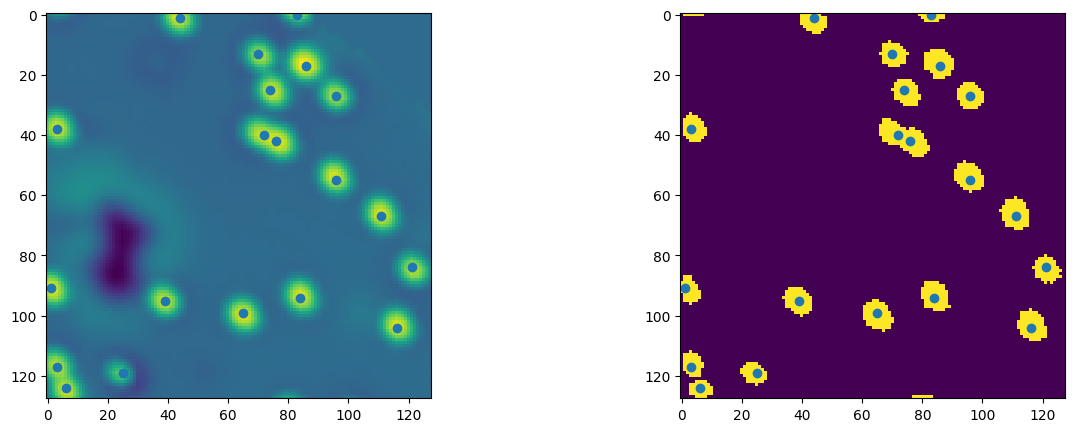

In [6]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
coords = get_coordinates(window_crops[18][1])
ax[0].scatter(coords[:,0], coords[:,1])
ax[0].imshow(window_crops[18][1])
ax[1].scatter(coords[:,0], coords[:,1])
ax[1].imshow(masks[18][1])

In [10]:
window_crops[:][1]

[0,
 array([[ 83,  83,  82, ...,  83,  83,  83],
        [ 83,  83,  83, ...,  83,  83,  83],
        [ 83,  83,  83, ...,  83,  83,  83],
        ...,
        [ 82,  82,  83, ..., 170, 186, 186],
        [ 83,  83,  83, ..., 148, 159, 151],
        [ 84,  84,  83, ..., 125, 133, 115]], dtype=uint8),
 array([259.82608696, 446.13043478])]

In [21]:
window_crops[3][1].shape

(128, 128)

In [8]:
from sklearn.model_selection import train_test_split
training_images, validation_images, training_labels, validation_labels = train_test_split(unet_img_aug, unet_mask_aug, test_size = 0.4)

NameError: name 'unet_img_aug' is not defined